# INLS 613 - Fake News Detection

Import libraries

In [238]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

## Dataset 1 - Train1.csv Exploration

In [239]:

data = pd.read_csv("train1.csv",encoding='utf_8') 




The data features are as follows:
- ID
- Title
- Author
- Text 
- Label (1 = "Unreliable", 0 = "Reliable")

We will only be using Title and Text as features to try and learn the concept of reliable vs unreliable news. 

Below is a sample set of the first 10 instances of data as an example: 

In [240]:
data.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [241]:
data.shape

(20800, 5)

In [242]:
data['label'].unique()

array([1, 0])

<function matplotlib.pyplot.show(*args, **kw)>

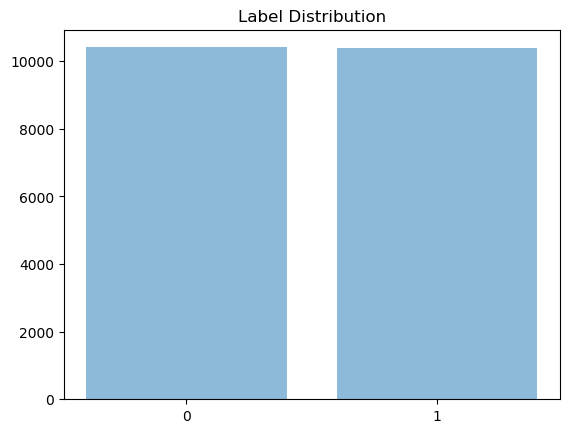

In [243]:
counts = data['label'].value_counts();
labels = np.unique(data['label']);
y_pos = np.arange(len(labels));
plt.bar(y_pos, counts, align='center', alpha=0.5);
plt.xticks(y_pos, labels);
plt.title('Label Distribution');
plt.show

Replacing 1's and 0's with "Unreliable" and "Reliable" for clarity:

In [244]:
data['label'] = data['label'].replace(1, 'Unreliable')
data['label'] = data['label'].replace(0, 'Reliable')
data.head(55)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,Unreliable
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,Reliable
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Unreliable
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,Unreliable
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Unreliable
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",Reliable
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,Unreliable
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",Reliable
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,Reliable
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,Reliable


In [245]:
data['text'].head()

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    Ever get the feeling your life circles the rou...
2    Why the Truth Might Get You Fired October 29, ...
3    Videos 15 Civilians Killed In Single US Airstr...
4    Print \nAn Iranian woman has been sentenced to...
Name: text, dtype: object

In [246]:
data['label'].value_counts()

Unreliable    10413
Reliable      10387
Name: label, dtype: int64

The dataset seems to have been read in appropriately and contains a near 50% split of labels, we can now begin the ML process. 

## Dataset 1 - Train1.csv - Machine Readable Conversion

In [247]:
from sklearn import preprocessing ### Importing a preprocessor to convert the labels in the target class.

In [248]:
train_class_y = ['Unreliable','Reliable']

In [249]:
le = preprocessing.LabelEncoder() ## Label encoder does the trick. 

In [250]:
le.fit(train_class_y) ## We are fitting the categories now. 

LabelEncoder()

In [251]:
train_y = le.transform(data['label'])

In [252]:
train_y ## These are out labels now. 

array([1, 0, 1, ..., 0, 1, 1])

In [253]:
le.transform(['Unreliable','Reliable','Reliable']) ### Just to check

array([1, 0, 0])

In [254]:
le.inverse_transform([0,1,1]) ### Doing an inverse of the transformation

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Reliable', 'Unreliable', 'Unreliable'], dtype='<U10')

### Working with the title

In [255]:
train_title = np.array(data['title'].astype('U'))

In [256]:
for row in train_title:
    print(row+"\n")

House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It

FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart

Why the Truth Might Get You Fired

15 Civilians Killed In Single US Airstrike Have Been Identified

Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery

Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart

Life: Life Of Luxury: Elton John’s 6 Favorite Shark Pictures To Stare At During Long, Transcontinental Flights

Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York Times

Excerpts From a Draft Script for Donald Trump’s Q&ampA With a Black Church’s Pastor - The New York Times

A Back-Channel Plan for Ukraine and Russia, Courtesy of Trump Associates - The New York Times

Obama’s Organizing for Action Partners with Soros-Linked ‘Indivisible’ to Disrupt Trump’s Agenda

BBC Comedy Sketch "Real Housewives of I


U.S. Health Care Lags Behind, Costs More Than Other Countries

Russia Considering Sending Edward Snowden Back to U.S. as ’Gift’ to Trump - Breitbart

nan

Russia Sends Bombers to Syria Using Base in Iran - The New York Times

The Anti-Police Epidemic

Study: Genital Mutilation Imposes Segregation on Immigrants’ American Daughters - Breitbart

A Mission to Bring STEM Skills, and Robots, to Children in West Africa - The New York Times

Are We To Love Al-Qaeda Or Fear It?

Breitbart News Daily: Dutch Election Results - Breitbart

Confusion as Clinton Cards changes name to Trump Cards

‘Fantastic Beasts’ Has a New Dumbledore: Jude Law - The New York Times

Government to Revive Pledge to Cut Migrant Benefits

Fifth Mexican Journalist Murdered in 90 Days

The FBI Agent Who Took Hillary’s Bribes Just Got Some Really Bad News

Rising Number Of Kids Growing Up Without Backyards Blamed For Aussie Cricket Slump

Ana Navarro Destroys Adulterer Newt Gingrich for Saying Megyn Kelly Is “Fascinated W


Apple iPhone, Once a Status Symbol in China, Loses Its Luster - The New York Times

DELINGPOLE: Paris - Trump Just Dodged A $2.5 Trillion Bullet

Flash-Mob Meditations To Occur At Voting Stations During Election

Malcolm X on Hillary Clinton and Donald Trump

Blame Government, Not Markets for Monopoly

Drudge, Downed by Cyberattack, Suspects Government Involvement - Breitbart

When Duterte Met Abe

Comment on Six Million Jews 1915-1938 by Jews Did World War and Open Borders – aladdinsmiraclelamp

7 reasons I'll vote for Trump

Trump sues ‘Trumpton’

Kissinger: Trump Need Not Keep “Positions Taken In the Campaign”… Promises Are Pillow Talk

Millions Of Drunk Cubs Fans Rioting In Heaven Following World Series Win - The Onion - America's Finest News Source

Dear John: Brooklyn Bridge Discourages Token of Love, With a Smile - The New York Times

Evan McMullin: President Donald Trump Is a ’Domestic Enemy’

I Voted Clinton. You Voted Trump. Let’s Talk. - The New York Times

Berlin Attack Po

LIKE FROM A MOVIE, MIKE PENCE DID SOMETHING AMAZING AT A TRUMP RALLY TODAY!

Why Every Man Must Take Control Of His Finances

‘No Vacancies’ for Blacks: How Donald Trump Got His Start, and Was First Accused of Bias - The New York Times

Normal Saline vs. Lactated Ringer’s: Results of a Phase 3 Randomized Quadruple-Blind Clinical Water Balloon Fight | GomerBlog

Oathkeeper Chapter 8

CNN’s Stelter: I Think Trump Leaks Are ’Partly’ Career Gov’t Officials and Obama Officials, Partly Trump Aides - Breitbart

Jeff Sessions Recuses Himself From Russia Inquiry - The New York Times

It’s No Longer A Secret: NASA Space Camera Footage Shows UFO

Of course, when you think about it, it was inevitable, says some smart-arsed twat

UFO Investigator - MAX SPIERS - Found Dead After Vomiting Black Liquid.

NATO and Turkey: Time to admit reality

What Enthusiasm Gap?: Watching Crowd Go NUTS As Hillary Speaks During Florida Downpour Is Amazing

Justice Clarence Thomas Describes Washington DC As “Broken”




Dutch Men Protest Homophobia by Holding Hands

Plane Gets Evacuated After Passenger Spots What’s On Muslim’s Phone

Trump: ’Sometimes You Have to Fuel the Well’ - Military ’More Important’ Than a Balanced Budget, ’We’ll Get There’ - Breitbart

Leaked audio recording reveals Theresa May's true fears about Brexit

Renowned Harvard Psychologist Says ADHD is Largely a Fraud

Wall St. Regulators Propose Stricter Pay Rules for Bankers - The New York Times

Mark Zuckerberg Calls for Universal Basic Income in America - Breitbart

Bernie Sanders and the Terms of Surrender - The New York Times

Aleksei Navalny, Russian Opposition Leader, Receives 15-Day Sentence - The New York Times

Superbugs: Big Pharma to blame for coming death of 700,000 people annually

In Sumner Redstone Affair, His Decline Upends Estate Planning - The New York Times

Donald Trump’s Threat to Close Door Reopens Old Wounds in Cuba - The New York Times

Sucker MCs to blame for everything

Emperor OctoTrumpus™ appoints speci

Germany’s Islamist Scene Growing: Security Chief

BREAKING : New Poll Has Trump in the LEAD in New Hampshire! – TruthFeed

Hillary Clinton and the President’s 'Longer Game.'

Why Did They Vote For Trump?

Anderson Cooper On Melania’s Cyber-Bullying Speech: Isn’t The Problem With HER Family? (VIDEO)

Arrest in Stockholm Truck Attack: ‘We Think He Is the Driver’ - The New York Times

nan

Bill O’Reilly Sets Return with ’No Spin News’ Podcast

Palestinian Authority Daily: Water The Soil With Martyr’s Blood

Whether they gave the Belize money back or not is a moot point!! thoughts?

Supplier: L.A. Area Ammunition Purchases up Nearly 400% - Breitbart

Tug Of War Between NATO And Trump: Who Will Win?

Unpaid Chernobyl veterans, underpaid teachers storm the Rada

Cultural Revolution Shaped Xi Jinping, From Schoolboy to Survivor - The New York Times

DANGER: Gold/Oil Ratio At Levels Last Seen During The Great Depression!

nan

nan

Duterte Wants Foreign Troops Out of Philippines in 2 Years

De


Brave New Digital World

Fmr Clinton Spox: There Are Developments That ’Call Into Question The Legitimacy’ of Trump’s Win ’Every Day’ - Breitbart

4 STEPS TO ENSURE YOUR AMMO STORES (VIRTUALLY) FOREVER

Nikki Haley’s Path: From Daughter of Immigrants to Trump’s Pick for U.N. - The New York Times

In the New Hollywood, Sumner Redstone Is a Man Out of Time - The New York Times

U.S. Says Russians Were Behind Cyberattacks on Antidoping Agency - The New York Times

“The Fed Failed ….” And that Changes Everything

Reader’s Guide to This Fall’s Big Book Awards - The New York Times

Dilma Rousseff, Facing Impeachment in Brazil, Has Alienated Many Allies - The New York Times

Comment on ObamaCare fallout: As premiums rise, so does cost to taxpayers by Glenn47

Attorney General Jeff Sessions Reforming Obama’s Lax Policies on Crime, Drug Trafficking - Breitbart

Jesus Christ's Real Tomb Finally Discovered in Jerusalem underneath Sepulchre Church

Why ‘This Is Fine’ Is the Meme This Year Deserve

The Dark Agenda Behind Globalism And Open Borders

Comment on 184 U.S. generals and admirals endorse Trump for Commander-In-Chief by Tonya Parnell

Peter Brimelow/Steve Curtis Audio Available–“Peter Brimelow–Longterm Immigrant”

WikiLeaks Releases 32nd Batch of Clinton Campaign Chair Podesta's Emails

Donald Trump’s ’Comprehensive Immigration Reform’ is Much Broader Than Expected - Breitbart

Чем закончатся изменения региональной динамики на Ближнем Востоке | Новое восточное обозрение

’Stop the Wall’ Phone App Created by Puerto Rican Professor

Former Classmate: Trump Smacked His Son So Hard It Knocked ‘Him To The Floor’ | Addicting Info | The Knowledge You Crave

It’s Harder for Clinton Supporters to Respect Trump Backers Than Vice Versa

Donald Trump Allies Focus Anger on Another Target: G.O.P. Leaders - The New York Times

Suspect in Fatal Subway Attack Pleads Not Guilty to Murder Charge - The New York Times

15,000 More Public Workers Are Fired in Turkey Crackdown - The New York T


Maisie Williams on ‘Game of Thrones,’ Blind Arya and Impatient Fans - The New York Times

Facebook Censors Strike Again as Liberal Fascism Rears its Ugly Head

Heseltine strangled dog as part of Thatcher cabinet initiation ceremony

nan

Putin's Anti-Corruption Purge continues: Now not even ministers are safe

America Needs To Wake Up – There is ZERO Hope For Our Country Until We Turn From Our Evil Ways

California Today: Your Voices - The New York Times

At Least 18 Die as Tornadoes Sweep Southeast U.S. - The New York Times

Armed Citizen Who Threw Wallet to Distracted Suspect: ’That’s When I Lit Him Up’ - Breitbart

The End of the Anglo-American Order - The New York Times

O’Keefe: Dems, Left, and Media Should Be Asked If They Disavow Violent Inauguration Protesters

Watch as Russia launches its latest super-stealth submarine

China repeatedly hacked US, stole data on nukes, FBI & war plans

Merkel: Worried about Islamisation? Just Sing Christmas Carols

BREAKING : Hillary Clinton H

Part 4 Of O’Keefe’s Project Veritas Videos Has Americans Asking 1 Question

7 Essential Things To Know Before Dating An Alpha Female

The Comey Confrontation: In Our New Third-World America, Corruption Is A Feature, Not A Bug

Prominent Jesuit Blames ’Morality of Capitalism’ for United Air Incident - Breitbart

WikiLeaks Hacked Email Reveals Inside Look at Hillary Campaign: "Just Need a 3rd Party Spoiler!"

Breaking: Top Clinton aide Huma Abedin Could Be A Spy | EndingFed News Network

Roger Ailes Leaves Fox News, and Rupert Murdoch Steps In - The New York Times

Tech CEOs Plan to Attend Jared Kushner-Led White House Summit - Breitbart

UPLIFTING: Anaheim Ducks Honor Bomb Detection K9 During ‘Military Appreciation Night’

Robert Redford for WaPo: ’45 Years After Watergate, The Truth is Again in Danger’ - Breitbart

GOP Sen Lee: POTUS Owes Congress a Plan ’Anytime We Send Our Young Men and Women Into Harm’s Way’ - Breitbart

Rodrigo Duterte, Scorned Abroad, Remains Popular in the Philip


Syria rejects West accusations over chemical attacks

Military Plane Approaching A UFO. See What Happens Then...

What It Feels Like to Ride in a Self-Driving Uber - The New York Times

There’s Already a Game Too Big to Install on the Nintendo Switch - Breitbart

Marco Rubio: President Trump Will Empower the People of Cuba, Not Communist Leaders - Breitbart

Verboten! Don’t speak German on the streets of post-Brexit Britain, warns lawyer

Thieves Steal Bees that Pollinate Central Valley Almonds

‘Gaps of Trust’ With Russia Bar a Syrian Truce, Obama Says - The New York Times

Clinton, FBIGate and the true depth of the ObamaGeddon

Head of Turkish delegation to Russia: "The Crimean people's choice must be recognized"

Toxic chemicals found in children’s Halloween makeup – study

nan

GaiaPortal – Serrated torches cleave the undesired

Will There Be Riots In America The Day After Donald Trump Wins The Presidency?

Trump Drops Truth Bombs on Cuba Regime, Policies - Breitbart

USA Today Sp

In [257]:
for word in str.split(train_title[0]):
    print("title_"+word)

title_House
title_Dem
title_Aide:
title_We
title_Didn’t
title_Even
title_See
title_Comey’s
title_Letter
title_Until
title_Jason
title_Chaffetz
title_Tweeted
title_It


In [258]:
for row in train_title:
    for word in str.split(row):
        word = word.replace(word,"title_"+word)

In [259]:
print(train_title)

['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'
 'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'
 'Why the Truth Might Get You Fired' ...
 'Macy’s Is Said to Receive Takeover Approach by Hudson’s Bay - The New York Times'
 'NATO, Russia To Hold Parallel Exercises In Balkans'
 'What Keeps the F-35 Alive']


## Feature Selection

#### TFIDF

In [260]:
train_text = data['text']
train_title = data['title']
shape = [train_text.shape, train_title.shape]
print(shape)

[(20800,), (20800,)]


In [261]:
from sklearn.feature_extraction.text import TfidfVectorizer ## Importing the library that will help us do this. 

In [262]:
tfvectorizer_1gram = TfidfVectorizer(min_df=1,stop_words='english',max_features=5000, ngram_range= (1,1))
tfvectorizer_2gram = TfidfVectorizer(min_df=1,stop_words='english',max_features=5000, ngram_range= (2,2))
tfvectorizer_3gram = TfidfVectorizer(min_df=1,stop_words='english',max_features=5000, ngram_range= (3,3))
tfvectorizer_12gram = TfidfVectorizer(min_df=1,stop_words='english',max_features=5000, ngram_range= (1,2))
tfvectorizer_23gram = TfidfVectorizer(min_df=1,stop_words='english',max_features=5000, ngram_range= (2,3))
tfvectorizer_13gram = TfidfVectorizer(min_df=1,stop_words='english',max_features=5000, ngram_range= (1,3))
## Ask yourself, why min_df =1? We are using english stopwords. 
####max_features=3000 

In [263]:
train_text_tfidf_1gram = tfvectorizer_1gram.fit_transform(train_text.values.astype('U'))
train_text_tfidf_2gram = tfvectorizer_2gram.fit_transform(train_text.values.astype('U'))
train_text_tfidf_3igram = tfvectorizer_3gram.fit_transform(train_text.values.astype('U'))
train_text_tfidf_12gram = tfvectorizer_12gram.fit_transform(train_text.values.astype('U'))
train_text_tfidf_23gram = tfvectorizer_23gram.fit_transform(train_text.values.astype('U'))
train_text_tfidf_13gram = tfvectorizer_13gram.fit_transform(train_text.values.astype('U'))
#train_title_tfidf = vectorizer.fit_transform(train_title.values.astype('U'))

In [264]:
print(tfvectorizer_1gram.get_feature_names()[0:50])

['00', '000', '10', '100', '11', '12', '125', '13', '14', '15', '150', '16', '17', '18', '19', '1960s', '1970s', '1980', '1980s', '1990', '1990s', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']


In [265]:
print(tfvectorizer_2gram.get_feature_names()[0:50])

['00 00', '00 eastern', '000 000', '000 acres', '000 emails', '000 feet', '000 jobs', '000 miles', '000 month', '000 new', '000 people', '000 votes', '000 year', '000 years', '10 000', '10 15', '10 2016', '10 2017', '10 30', '10 billion', '10 brainforce', '10 days', '10 finally', '10 million', '10 minutes', '10 percent', '10 times', '10 year', '10 years', '100 000', '100 billion', '100 days', '100 million', '100 people', '100 percent', '100 years', '11 000', '11 16', '11 2001', '11 2016', '11 2017', '11 attacks', '11 days', '11 million', '11 percent', '11 years', '12 000', '12 2016', '12 2017', '12 million']


In [266]:
print(tfvectorizer_3gram.get_feature_names()[0:50])

['00 00 eastern', '00 eastern listen', '000 000 000', '000 pageviews month', '000 people killed', '000 plate dinner', '000 years ago', '05 3222705 html', '10 000 people', '10 27 2016', '10 brainforce 25', '10 days clicking', '10 downing street', '10 replies comment', '10 years ago', '100 000 american', '100 000 people', '100 days office', '100 leader authoritarian', '100 years ago', '11 03 2016', '11 2001 attacks', '11 act terrorism', '11 days considerable', '11 days election', '11 terrorist attacks', '11 year old', '11 years ago', '12 year old', '125 6am 9am', '125 weekdays 00', '12hdlgeeua87t2ju8m4tbro247yj5u2tvp join vote', '13 year old', '14 year old', '15 year old', '15 years ago', '16 year old', '16 years ago', '17 local acrobats', '17 year old', '1980s mr obama', '1999 2015 godlikeproductions', '20 000 people', '20 million people', '20 th century', '20 trillion dollar', '20 years ago', '200 e1476824046577 jpg', '2008 financial crisis', '2008 presidential campaign']


In [267]:
print(tfvectorizer_12gram.get_feature_names()[0:50])

['00', '000', '000 people', '10', '10 000', '10 percent', '10 years', '100', '100 000', '11', '12', '125', '13', '14', '15', '15 years', '150', '16', '17', '18', '19', '1960s', '1970s', '1980', '1980s', '1990', '1990s', '1991', '1992', '1994', '1995', '1996', '1997', '1998', '1999', '20', '20 000', '20 percent', '20 years', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']


In [268]:
print(tfvectorizer_23gram.get_feature_names()[0:50])

['00 00', '00 00 eastern', '00 eastern', '000 000', '000 emails', '000 jobs', '000 miles', '000 month', '000 new', '000 people', '000 votes', '000 year', '000 years', '000 years ago', '10 000', '10 15', '10 2016', '10 2017', '10 30', '10 billion', '10 brainforce', '10 brainforce 25', '10 days', '10 finally', '10 million', '10 minutes', '10 percent', '10 times', '10 years', '10 years ago', '100 000', '100 days', '100 million', '100 people', '100 percent', '100 years', '11 16', '11 2001', '11 2016', '11 2017', '11 attacks', '11 days', '11 million', '11 percent', '11 years', '12 000', '12 2016', '12 2017', '12 million', '12 months']


In [269]:
print(tfvectorizer_13gram.get_feature_names()[0:50])

['00', '000', '000 people', '10', '10 000', '10 percent', '10 years', '100', '100 000', '11', '12', '125', '13', '14', '15', '15 years', '150', '16', '17', '18', '19', '1960s', '1970s', '1980', '1980s', '1990', '1990s', '1991', '1992', '1994', '1995', '1996', '1998', '1999', '20', '20 percent', '20 years', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011']


In [272]:
print(train_text_tfidf_1gram.shape)
print(train_text_tfidf_1gram)

(20800, 5000)
  (0, 2220)	0.12998965725814143
  (0, 241)	0.20366498704400487
  (0, 1358)	0.18450926029263842
  (0, 936)	0.3834337219642813
  (0, 2621)	0.2438936918578161
  (0, 2441)	0.2225881018817362
  (0, 4667)	0.08651012212524212
  (0, 3081)	0.053305474757926984
  (0, 64)	0.05550456624931224
  (0, 48)	0.03847069642471219
  (0, 4352)	0.045827157072875185
  (0, 288)	0.01948904289077305
  (0, 4745)	0.09972129514668542
  (0, 2265)	0.03401675562149033
  (0, 1131)	0.09651690164512464
  (0, 2847)	0.031305494168873856
  (0, 464)	0.03221550868495532
  (0, 1147)	0.04258250660000228
  (0, 2636)	0.04327504042012638
  (0, 1447)	0.03531368341141346
  (0, 4950)	0.1447356365792754
  (0, 3282)	0.08108472239551065
  (0, 4945)	0.05773052496394794
  (0, 4878)	0.02192925667400458
  (0, 1785)	0.19925560356464667
  :	:
  (20799, 1325)	0.07931155967929972
  (20799, 4578)	0.28399572816317825
  (20799, 4640)	0.0667235943623609
  (20799, 2886)	0.02782280556435485
  (20799, 4793)	0.028278464627164285
  (20799,

In [274]:
train_text_tfidf_1gram_array = train_text_tfidf_1gram.toarray()
train_text_tfidf_2gram_array = train_text_tfidf_2gram.toarray()
train_text_tfidf_3gram_array = train_text_tfidf_3igram.toarray()
train_text_tfidf_12gram_array = train_text_tfidf_12gram.toarray()
train_text_tfidf_23gram_array = train_text_tfidf_23gram.toarray()
train_text_tfidf_13gram_array = train_text_tfidf_13gram.toarray()

In [161]:
train_text_tfidf_array[2]

array([0., 0., 0., ..., 0., 0., 0.])

In [162]:
tfvectorizer.inverse_transform(train_text_tfidf_array[0]) ## just to check what all features are there. 

[array(['28 2016', '30 2016', 'anthony weiner', 'appear pertinent',
        'classified information', 'clinton email', 'clinton email server',
        'comey letter', 'committee chairman', 'commons license',
        'creative commons', 'creative commons license', 'didn know',
        'director james', 'director james comey', 'doesn mean', 'don know',
        'email server', 'emails appear', 'fbi director',
        'fbi director james', 'fbi director james comey', 'follow twitter',
        'hillary clinton', 'hillary clinton email', 'house intelligence',
        'house republican', 'image courtesy', 'james comey',
        'jason chaffetz', 'like know', 'look like', 'looks like',
        'make good', 'members house', 'mitt romney', 'north carolina',
        'october 28', 'october 28 2016', 'october 30', 'october 30 2016',
        'percent vote', 've got'], dtype='<U42')]

## Naive Bayes!

In [164]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import cross_validate

In [285]:
mnb = MultinomialNB(alpha=1.0) # alpha is smoothing, setting to 1 is laplace smoothing
accuracy = cross_val_score(mnb, train_text_tfidf_13gram_array,train_y, cv=10)
print(accuracy)

print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))


precision = cross_val_score(mnb, train_text_tfidf_13gram_array,train_y, scoring='precision', cv=10)

print(precision)
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))

[0.90245074 0.90773667 0.90293128 0.90625    0.92259615 0.90432692
 0.90576923 0.8999519  0.8989899  0.90764791]
Accuracy: 0.91 (+/- 0.01)
[0.92762487 0.93191057 0.91749503 0.92641129 0.94444444 0.92439516
 0.93333333 0.92805755 0.92441267 0.94172737]
Precision: 0.93 (+/- 0.02)


In [65]:
mnb.fit(train_text_tfidf_array,train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### TFIDF Naive Bayes Results (10 Fold CV)

grams  | acc | prec

1gram  | .89 | .92

2gram  | .93 | .94

3gram  | .89 | .87

12gram| .9  | .93

23gram| .93 | .94

13gram| .91 | .93